<a href="https://colab.research.google.com/github/adhello007/ML-Projects/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os 
import cv2
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import xml.etree.ElementTree as xt 
import plotly.express as px 
import matplotlib.pyplot as plt 

from PIL import Image
from skimage import io 
from glob import glob 
from keras.models import Model 
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split 
from keras.optimizers import Adam,RMSprop 
from keras.layers import Dense, Dropout, Flatten 

Viewing an XML file 

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.getcwd()

'/content'

In [5]:
os.mkdir('/content/localizationDataset')

In [6]:
xml_example = '/content/drive/MyDrive/training_images/mushroom_59.xml'

In [7]:
with open(xml_example, 'r') as f:
    data = f.read()
    content = BeautifulSoup(data, 'xml')
content

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>single mushroom</folder>
<filename>mushroom_59.jpg</filename>
<path>C:\Users\Muhammed Buyukkinaci\Downloads\single mushroom\mushroom_59.jpg</path>
<source>
<database>Unknown</database>
</source>
<size>
<width>227</width>
<height>227</height>
<depth>3</depth>
</size>
<segmented>0</segmented>
<object>
<name>mushroom</name>
<pose>Unspecified</pose>
<truncated>0</truncated>
<difficult>0</difficult>
<bndbox>
<xmin>93</xmin>
<ymin>69</ymin>
<xmax>177</xmax>
<ymax>203</ymax>
</bndbox>
</object>
</annotation>

Parsing XML and getting labels 


In [8]:
path = sorted(glob('/content/drive/MyDrive/training_images/*.xml'))
y = []

for file in path: 
  label = 0 
  info = xt.parse(file)
  root = info.getroot()
  obj = root.find('object')

  label_obj = (obj.find('name').text)
  if "cucumber" in label_obj:
      label = 1
  elif "eggplant" in label_obj:
        label = 2
  elif "mushroom" in label_obj:
        label = 3

  bndbox = obj.find('bndbox')
  xmin = (bndbox.find('xmin').text)
  xmax = (bndbox.find('xmax').text)
  ymin = (bndbox.find('ymin').text)
  ymax = (bndbox.find('ymax').text)
    
    #append the results to our target
  y.append([int(label),int(xmin),int(ymin),int(xmax),int(ymax)])

In [9]:
y

[[1, 23, 42, 206, 199],
 [1, 13, 70, 219, 160],
 [1, 8, 42, 221, 200],
 [1, 22, 67, 218, 158],
 [1, 15, 56, 212, 156],
 [1, 24, 82, 204, 154],
 [1, 40, 89, 216, 221],
 [1, 14, 44, 208, 205],
 [1, 28, 71, 193, 174],
 [1, 53, 86, 149, 175],
 [1, 32, 74, 200, 132],
 [1, 6, 74, 221, 157],
 [1, 12, 51, 216, 165],
 [1, 16, 82, 208, 172],
 [1, 26, 22, 201, 172],
 [1, 8, 71, 215, 152],
 [1, 13, 129, 196, 170],
 [1, 7, 82, 219, 191],
 [1, 31, 73, 209, 142],
 [1, 96, 63, 219, 164],
 [1, 24, 61, 196, 185],
 [1, 14, 97, 214, 184],
 [1, 8, 38, 219, 180],
 [1, 24, 26, 200, 197],
 [1, 36, 11, 215, 207],
 [1, 74, 37, 150, 187],
 [1, 21, 29, 202, 198],
 [1, 16, 52, 210, 184],
 [1, 4, 35, 225, 196],
 [1, 29, 74, 195, 121],
 [1, 29, 77, 209, 172],
 [1, 38, 57, 207, 191],
 [1, 37, 25, 192, 180],
 [1, 12, 47, 217, 135],
 [1, 25, 67, 201, 163],
 [1, 9, 85, 221, 141],
 [1, 22, 22, 218, 202],
 [1, 11, 136, 198, 179],
 [1, 16, 77, 210, 139],
 [1, 11, 31, 217, 208],
 [1, 16, 66, 224, 143],
 [1, 27, 62, 212, 138

Reading Images 


In [10]:
X = []

images_path = sorted(glob('/content/drive/MyDrive/training_images/*.jpg'))

for image in images_path:
  img = cv2.imread(image, cv2.COLOR_BGR2RGB)
  X.append(img)

In [11]:
X[0].shape # x is  a list of all images and each list entry is a numpy array img

(227, 227, 3)

In [12]:
y[1][1:] #bounding box coordinates of the second image in the list. 

[13, 70, 219, 160]

Adding the bounding box on the image after finding its coordinates by parsing through the xml file. 


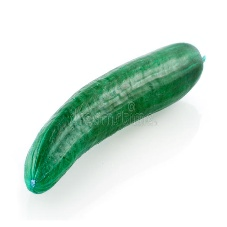

In [13]:
bbox = y[0][1:]
img_example = X[0]
fig = px.imshow(img_example)
fig.update_layout(width=800, height = 600, margin = dict(l=10,r=10,b=10,t=10))
fig.add_shape(type='rect',x0=bbox[0], x1=bbox[2], y0=bbox[1], y1=bbox[3], xref='x', yref='y',line_color='cyan')


In [14]:
X = np.array(X) #converted from a list to a numpy array

In [15]:
X.shape

(186, 227, 227, 3)

In [16]:
y = np.array(y)

In [17]:
y.shape

(186, 5)

Train test split 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [19]:
y_train.shape

(148, 5)

In [20]:
categ_train = y_train[:,0:1]  #y label of whether its class 1 2 or 3
categ_test = y_test[:,0:1] 
bbox_train = y_train[:,1:] # bounding bbox of all those classes
bbox_test = y_test[:,1:]


In [21]:
categ_train = tf.keras.utils.to_categorical(categ_train)
categ_test = tf.keras.utils.to_categorical(categ_test)

In [22]:
categ_test

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [23]:
#Load InceptionV3
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(227,227,3))

87910968/87910968 [==============================] - 5s 0us/step


In [24]:
inception.trainable = True #Set layers to trainable

last_layer = inception.get_layer('mixed10') #get last layer in inception

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

last layer output shape:  (None, 5, 5, 2048)


In [25]:
x = Flatten()(layer_output)
x1 = Dropout(0.3)(x)
x2 = Dense(4112,activation="relu")(x1)
drop1 = Dropout(0.3)(x2)
x3 = Dense(1028,activation="relu")(x2)
x4 = Dense(1028,activation="relu")(x3)
drop1 = Dropout(0.5)(x4)

x5 = Dense(256,activation="relu")(drop1)
drop2 = Dropout(0.3)(x5)
classification_output = Dense(4,activation='softmax',name = 'classification')(x2)
bounding_box_output = Dense(4,name = 'bounding_box')(x5)
model = tf.keras.Model(inputs = inception.inputs, outputs = [classification_output, bounding_box_output])

In [26]:
def scheduler(epoch, lr):
    """
    Applies exponential decay
    Args:
    epoch: Epoch to start the decay at
    lr: current learning rate
    """
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(-0.12)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [27]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })

In [28]:
r= model.fit(X_train,[categ_train,bbox_train],epochs=70,validation_data=(X_test,[categ_test,bbox_test]),callbacks=[callback])

Epoch 1/70
5/5 [==============================] - 28s 2s/step - loss: 14593.8008 - classification_loss: 1.8568 - bounding_box_loss: 14591.9443 - classification_accuracy: 0.3311 - bounding_box_mse: 14591.9443 - val_loss: 848.9148 - val_classification_loss: 1.8329 - val_bounding_box_loss: 847.0818 - val_classification_accuracy: 0.4737 - val_bounding_box_mse: 847.0818 - lr: 1.0000e-04
Epoch 2/70
5/5 [==============================] - 1s 274ms/step - loss: 3379.8179 - classification_loss: 1.5655 - bounding_box_loss: 3378.2524 - classification_accuracy: 0.2905 - bounding_box_mse: 3378.2524 - val_loss: 19161.4082 - val_classification_loss: 1.3358 - val_bounding_box_loss: 19160.0723 - val_classification_accuracy: 0.3947 - val_bounding_box_mse: 19160.0723 - lr: 1.0000e-04
Epoch 3/70
5/5 [==============================] - 1s 277ms/step - loss: 2348.2461 - classification_loss: 1.3080 - bounding_box_loss: 2346.9382 - classification_accuracy: 0.3716 - bounding_box_mse: 2346.9382 - val_loss: 1131.8

In [29]:
r.history.keys()

dict_keys(['loss', 'classification_loss', 'bounding_box_loss', 'classification_accuracy', 'bounding_box_mse', 'val_loss', 'val_classification_loss', 'val_bounding_box_loss', 'val_classification_accuracy', 'val_bounding_box_mse', 'lr'])

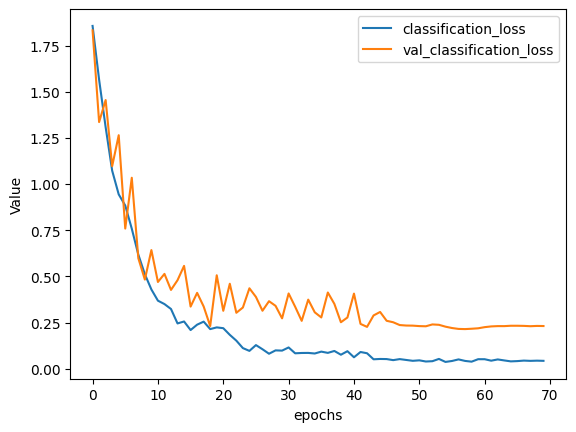

In [30]:
classification_loss = r.history['classification_loss']
val_classification_loss  = r.history['val_classification_loss']
plt.plot(range(len(classification_loss)),classification_loss,label = "classification_loss")
plt.plot(range(len(classification_loss)),val_classification_loss,label ="val_classification_loss")
plt.xlabel('epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

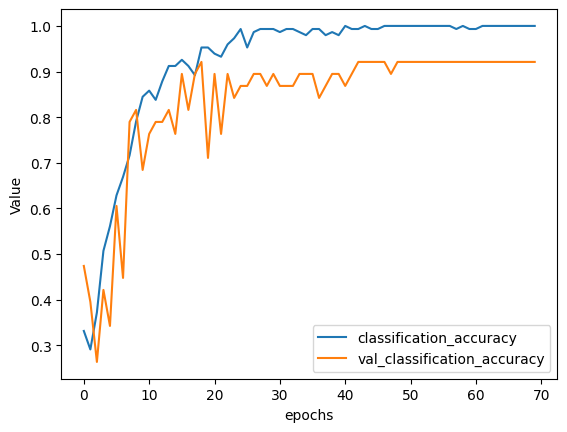

In [31]:
classification_accuracy = r.history['classification_accuracy']
val_classification_accuracy  = r.history['val_classification_accuracy']
plt.plot(range(len(classification_accuracy)),classification_accuracy,label = "classification_accuracy")
plt.plot(range(len(classification_accuracy)),val_classification_accuracy,label ="val_classification_accuracy")
plt.xlabel('epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

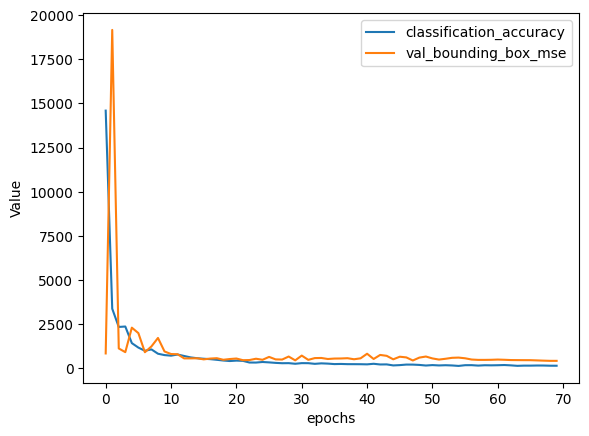

In [32]:
bounding_box_mse = r.history['bounding_box_mse']
val_bounding_box_mse  = r.history['val_bounding_box_mse']
plt.plot(range(len(bounding_box_mse)),bounding_box_mse,label = "classification_accuracy")
plt.plot(range(len(bounding_box_mse)),val_bounding_box_mse,label ="val_bounding_box_mse")
plt.xlabel('epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

Evaluation 


In [34]:
def predict(path, model, from_url=False):
    """
    passes an image to a trained model and returns annotated image

    Args:
    path:  path containing the image or a list of paths
    model:  pretrained model instance
    from_url: (boolen) to check if the path is a url
    """
    # Check if the path is a list
    if type(path) == list:
        # loop over each path and read the image
        for p in path:
            if from_url:
                image = io.imread(p)
            else:
                image = cv2.imread(p)
    # Check if the type of the path is a string
    elif type(path) == str:
            # read the given image
            if from_url:
                image = io.imread(path)
            else:
                image = cv2.imread(path)
    # Resize the image into the appropriate shape    
    image = cv2.resize(image,(227,227))
    # get model predictions
    categ,bbox = model.predict(np.array([image]))
    # Get class of the highest given probability
    categ = np.argmax(categ)
    # flatten the bounding box array and cast it into integer
    bbox = bbox.flatten()
    bbox = bbox.astype(int)
    # draw a rectangle on the image using the predicted bbox coordinates
    image = cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,0,0),1)
    # set prediction class to an empty string
    prediction = ''
    # set the prediction to the name of the given class according to the model's prediction
    if categ == 1:
        prediction = 'Cucumber'
    elif categ == 2:
        prediction = 'Egg Plant'
    elif categ == 3:
        prediction = 'Mushroom'
    # Put the text of the prediction on the image
    final_img = cv2.putText(image,prediction,(bbox[0],bbox[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,0,0),1,255)
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 160ms/step


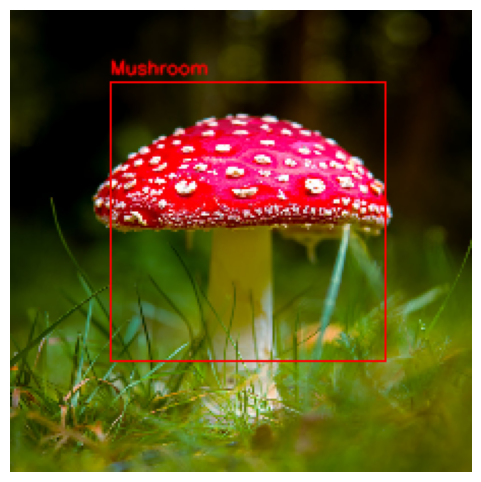

In [37]:
predict('https://images.unsplash.com/photo-1630921121767-81e86d066a5d?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTd8fG11c2hyb29tfGVufDB8fDB8fA%3D%3D&w=1000&q=80',model,True)

1/1 [==============================] - 0s 67ms/step


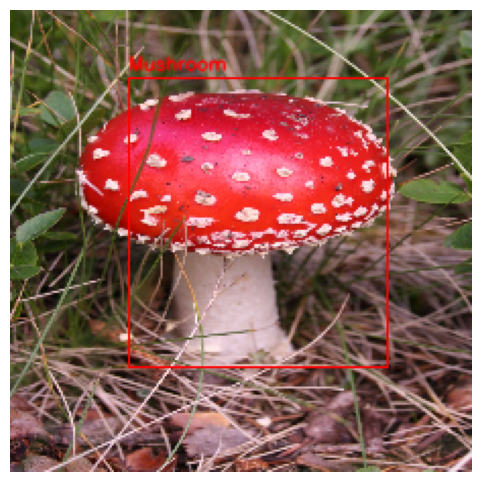

In [38]:
predict('https://upload.wikimedia.org/wikipedia/commons/c/c2/Amanita_muscaria_%28fly_agaric%29.JPG',model,True)

1/1 [==============================] - 0s 40ms/step


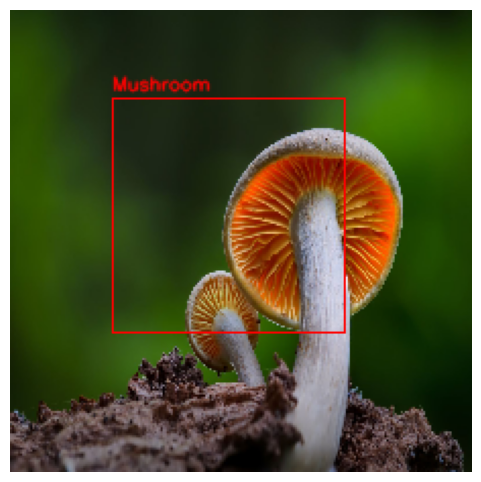

In [40]:
predict('https://cdn.britannica.com/90/236590-050-27422B8D/Close-up-of-mushroom-growing-on-field.jpg',model,True)